In [60]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')


In [61]:
image_path = '../input/flickr8k/Images'


In [62]:
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [63]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

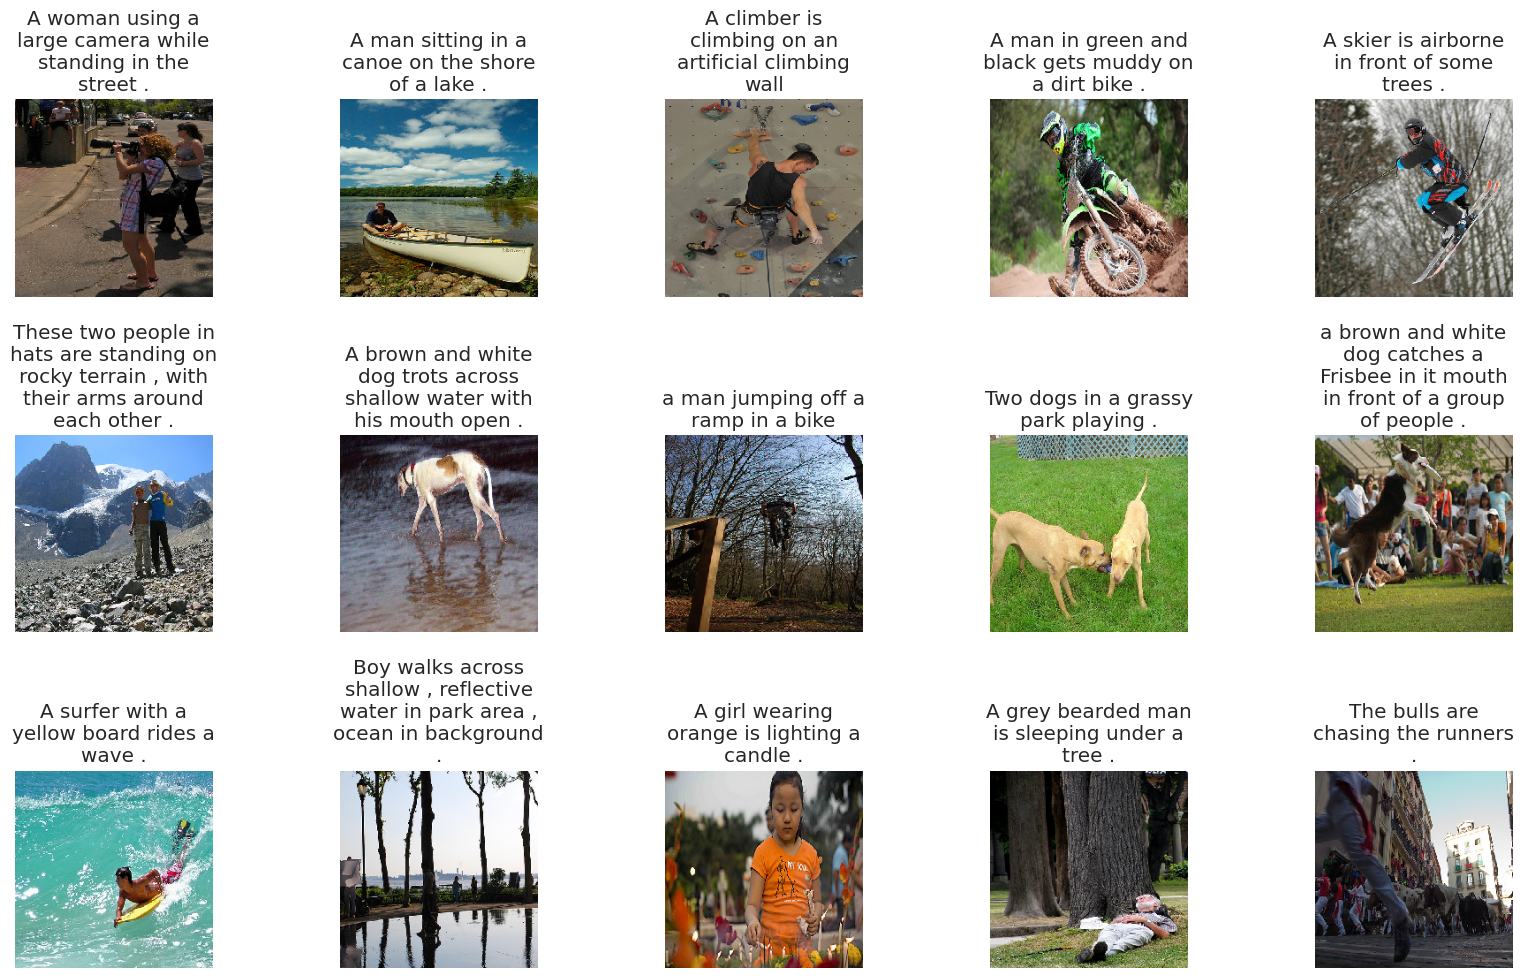

In [64]:
display_images(data.sample(15))


In [65]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data


In [66]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [67]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [68]:
weights_path = '/kaggle/input/trongso/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'
# Khởi tạo mô hình DenseNet201 với trọng số cục bộ và Global Average Pooling
model = DenseNet201(weights=weights_path, include_top=False, pooling='avg')  # Thêm pooling='avg'
fe = Model(inputs=model.input, outputs=model.output)  # Đầu ra giờ là (None, 1920)

# Kích thước ảnh
img_size = 224

# Từ điển lưu trữ đặc trưng của ảnh
features = {}

# Trích xuất đặc trưng từ tất cả ảnh
for image in tqdm(data['image'].unique().tolist(), desc="Extracting features"):
    try:
        # Đường dẫn đầy đủ tới ảnh
        img_path = os.path.join(image_path, image)

        # Đọc và xử lý ảnh
        img = load_img(img_path, target_size=(img_size, img_size))  # Resize ảnh
        img = img_to_array(img)  # Chuyển thành mảng numpy
        img = img / 255.0  # Chuẩn hóa pixel
        img = np.expand_dims(img, axis=0)  # Thêm batch dimension

        # Trích xuất đặc trưng bằng mô hình
        feature = fe.predict(img, verbose=0)

        # Lưu đặc trưng vào dictionary
        features[image] = feature
    except Exception as e:
        print(f"Error processing image {image}: {e}")

print(f"Feature extraction completed. Total images processed: {len(features)}")


Extracting features: 100%|██████████| 8091/8091 [12:57<00:00, 10.41it/s]

Feature extraction completed. Total images processed: 8091


In [69]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [70]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [71]:
from tensorflow.keras.utils import plot_model


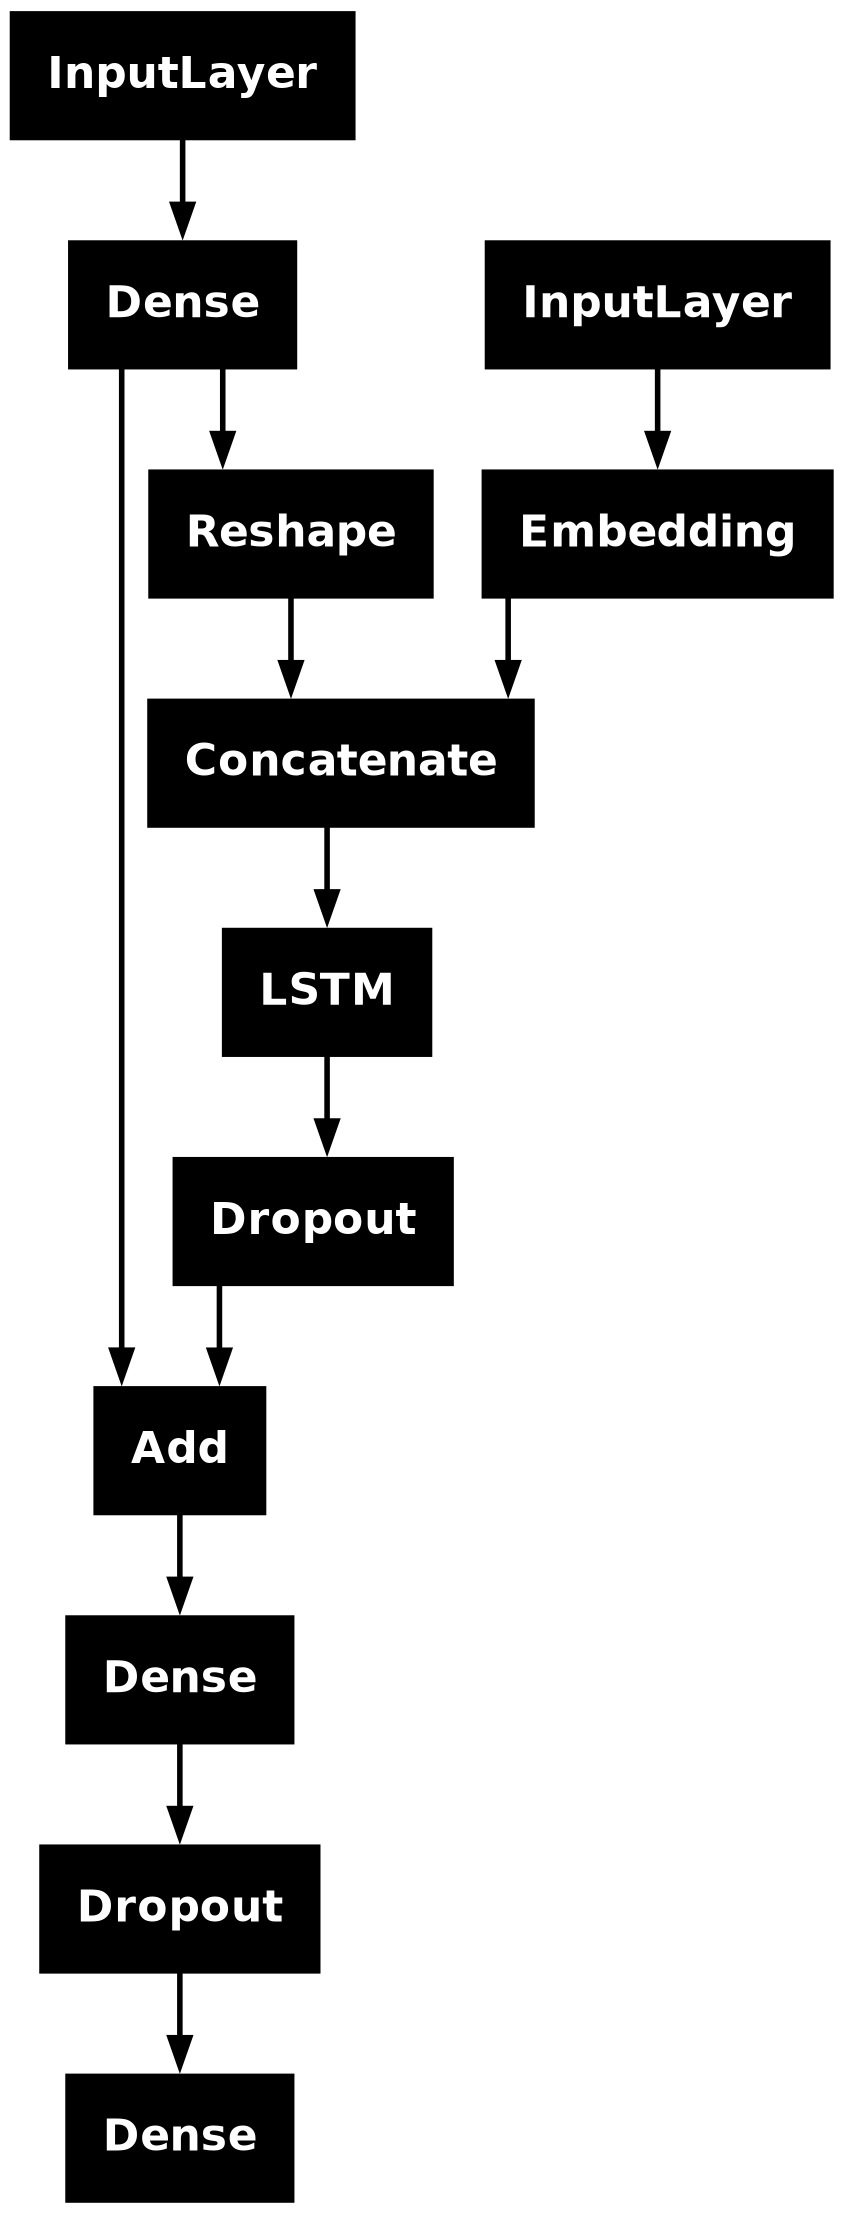

In [72]:
plot_model(caption_model)


In [73]:
caption_model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    491,776 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 256)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 34, 256)   │  2,172,160 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 35, 256)   │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [75]:
# Đường dẫn file lưu mô hình
model_name = "model.keras" 

# Callback lưu mô hình tốt nhất (ModelCheckpoint)
checkpoint = ModelCheckpoint(
    filepath=model_name,         # Đường dẫn file lưu
    monitor="val_loss",          # Theo dõi giá trị 'val_loss'
    mode="min",                  # Lưu khi 'val_loss' đạt giá trị nhỏ nhất
    save_best_only=True,         # Chỉ lưu mô hình tốt nhất
    verbose=1                    # Hiển thị thông báo trong quá trình huấn luyện
)

# Callback dừng sớm khi không cải thiện (EarlyStopping)
earlystopping = EarlyStopping(
    monitor="val_loss",          # Theo dõi giá trị 'val_loss'
    min_delta=0,                 # Ngưỡng cải thiện tối thiểu
    patience=5,                  # Số epoch chờ trước khi dừng
    verbose=1,                   # Hiển thị thông báo
    restore_best_weights=True    # Phục hồi trọng số tốt nhất
)

# Callback giảm tốc độ học khi không cải thiện (ReduceLROnPlateau)
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss",          # Theo dõi giá trị 'val_loss'
    patience=3,                  # Số epoch chờ trước khi giảm
    factor=0.2,                  # Hệ số giảm tốc độ học
    verbose=1,                   # Hiển thị thông báo
    min_lr=1e-8                  # Giá trị nhỏ nhất của tốc độ học
)

# Danh sách các callback
callbacks = [checkpoint, earlystopping, learning_rate_reduction]

print("Callbacks initialized successfully!")

Callbacks initialized successfully!


In [76]:
history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 5.6612
Epoch 1: val_loss improved from inf to 4.16658, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 325s 595ms/step - loss: 5.6600 - val_loss: 4.1666 - learning_rate: 0.0010
Epoch 2/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 4.2028
Epoch 2: val_loss improved from 4.16658 to 3.88044, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 85s 157ms/step - loss: 4.2025 - val_loss: 3.8804 - learning_rate: 0.0010
Epoch 3/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 3.9077
Epoch 3: val_loss improved from 3.88044 to 3.75247, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 87s 160ms/step - loss: 3.9076 - val_loss: 3.7525 - learning_rate: 0.0010
Epoch 4/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 3.7403
Epoch 4: val_loss improved from 3.75247 to 3.68406, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 85s 156ms/step - loss: 3.7403 - val_loss: 3.6841 - learning_rate: 0.0010

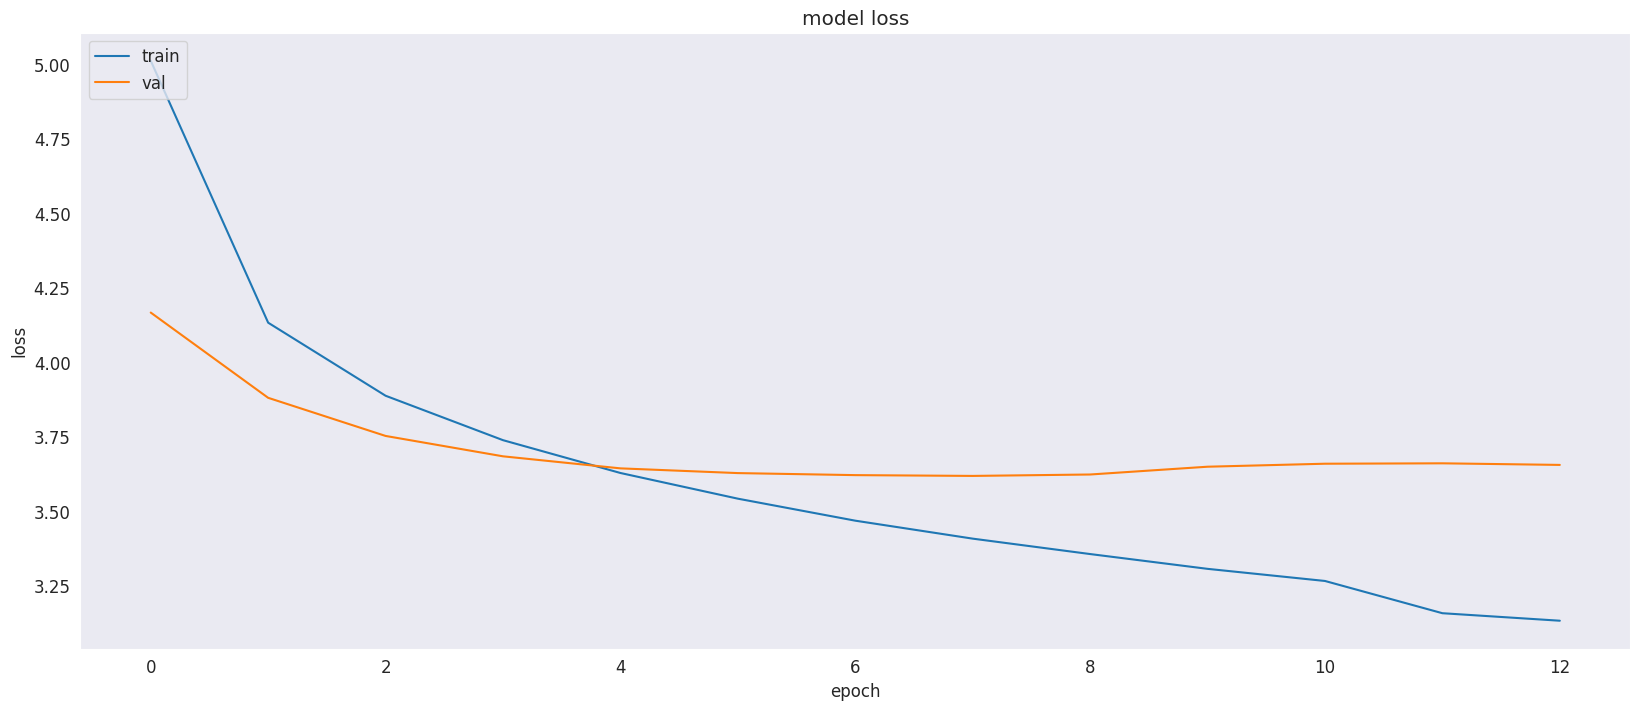

In [77]:
#Biểu đồ so sánh 
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [78]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [79]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [80]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [81]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

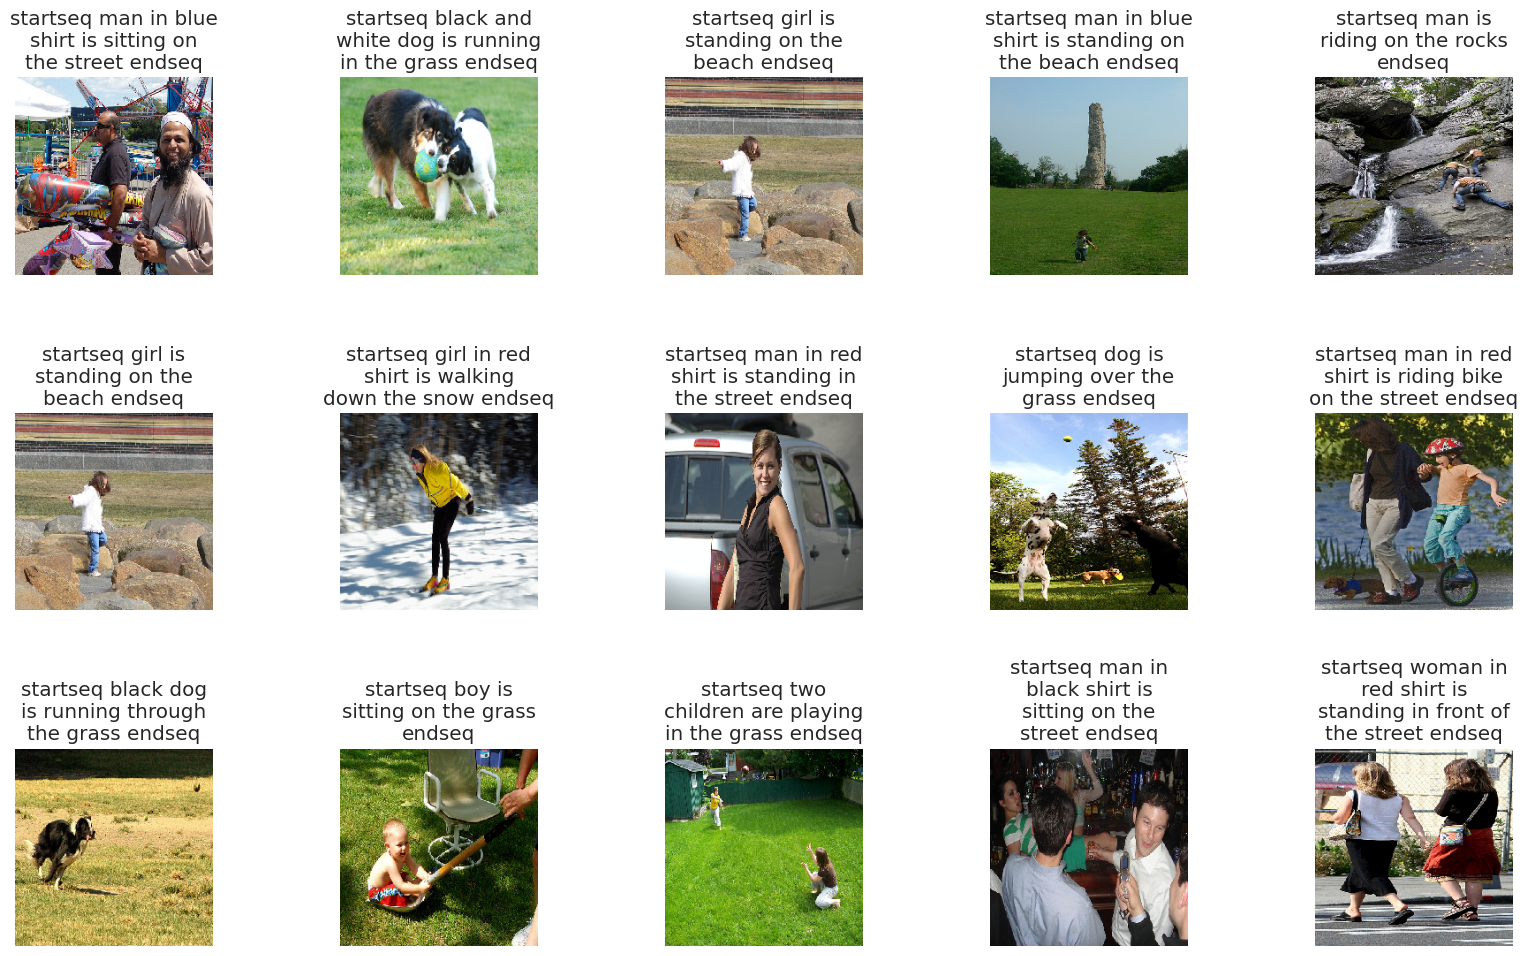

In [82]:
display_images(samples)


Captions loaded successfully!
Model loaded successfully!
Feature extractor initialized successfully!
Features extracted for 0 images.
Feature for 1001773457_577c3a7d70.jpg not found. Extracting...


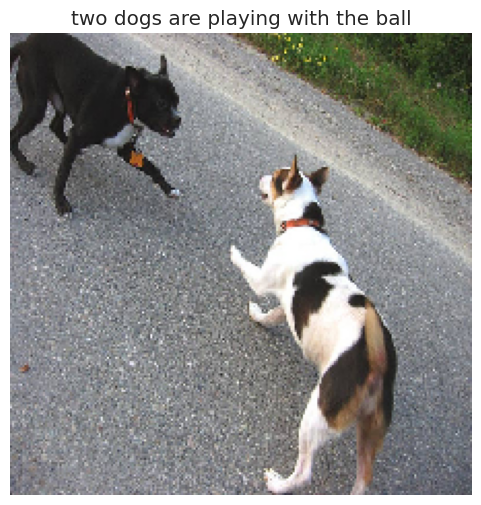

Generated Caption: two dogs are playing with the ball


In [88]:
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from tensorflow.keras.applications.densenet import DenseNet201

# Tải dữ liệu chú thích từ file captions.txt
captions_path = "/kaggle/input/flickr8k/captions.txt"
if not os.path.exists(captions_path):
    print(f"Error: Captions file {captions_path} does not exist.")
else:
    # Đọc file chú thích
    captions_df = pd.read_csv(captions_path, delimiter='\t', header=None, names=['image', 'caption'])
    captions_df['image'] = captions_df['image'].apply(lambda x: x.split("#")[0])  # Lấy tên file ảnh
    print("Captions loaded successfully!")

# Tải lại mô hình đã lưu
saved_model_path = "/kaggle/working/model.keras"
if not os.path.exists(saved_model_path):
    print(f"Error: Model file {saved_model_path} does not exist.")
else:
    saved_model = load_model(saved_model_path)
    print("Model loaded successfully!")

# Tải trọng số và mô hình DenseNet201 cho trích xuất đặc trưng
weights_path = "/kaggle/input/trongso/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
if not os.path.exists(weights_path):
    print(f"Error: Weights file {weights_path} does not exist.")
else:
    base_model = DenseNet201(weights=weights_path, include_top=False, pooling="avg")
    feature_extractor = base_model
    print("Feature extractor initialized successfully!")

# Hàm trích xuất đặc trưng từ ảnh
def extract_features(image_path, model):
    try:
        img = load_img(image_path, target_size=(224, 224))  # Resize ảnh
        img = img_to_array(img)  # Chuyển thành mảng numpy
        img = img / 255.0  # Chuẩn hóa pixel
        img = np.expand_dims(img, axis=0)  # Thêm chiều batch
        feature = model.predict(img, verbose=0)  # Dự đoán đặc trưng
        return feature
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Tạo dictionary lưu trữ đặc trưng cho các ảnh
features = {}
image_dir = "/kaggle/input/flickr8k/Images"
for image_name in captions_df['image'].unique():
    image_path = os.path.join(image_dir, image_name)
    if os.path.exists(image_path):
        features[image_name] = extract_features(image_path, feature_extractor)
print(f"Features extracted for {len(features)} images.")

# Hàm để chuyển từ chỉ số về từ trong tokenizer
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Hàm dự đoán chú thích với mô hình đã lưu
def predict_caption_with_saved_model(model, image, tokenizer, max_length, features):
    image_name = os.path.basename(image)
    if image_name not in features:
        print(f"Feature for {image_name} not found. Extracting...")
        features[image_name] = extract_features(image, feature_extractor)

    feature = features[image_name]  # Lấy đặc trưng của ảnh từ features (tên file)
    in_text = "startseq"
    for _ in range(max_length):
        # Mã hóa chuỗi hiện tại thành chỉ số
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Dự đoán từ tiếp theo
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        # Lấy từ tương ứng với chỉ số dự đoán
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break

        in_text += " " + word

        # Kết thúc nếu gặp từ "endseq"
        if word == "endseq":
            break

    # Loại bỏ "startseq" và "endseq" khỏi chuỗi kết quả
    return in_text.split(" ")[1:-1]

# Đường dẫn tuyệt đối đến ảnh cần dự đoán
image_path_full = "/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg"

# Kiểm tra xem ảnh có tồn tại trong đường dẫn không
if not os.path.exists(image_path_full):
    print(f"Error: Image path {image_path_full} does not exist.")
else:
    # Dự đoán chú thích cho ảnh
    predicted_caption = predict_caption_with_saved_model(
        saved_model, image_path_full, tokenizer, max_length, features
    )

    # Hiển thị ảnh và chú thích
    img = load_img(image_path_full, target_size=(224, 224))
    img = img_to_array(img) / 255.0  # Chuẩn hóa ảnh

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(" ".join(predicted_caption))
    plt.show()

    print(f"Generated Caption: {' '.join(predicted_caption)}")
